In [33]:
%matplotlib inline

import warnings

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

from core.database import *


# set pre-defined params
rcParams['figure.figsize'] = 15, 6
window = 15

# define db
db = Database(name='bdf')

# defne commodity
commodity = 'gold'

# pull gold and silver
data = db.get_commodity(commodity)
data.set_index('date', inplace=True)

data


,commodity,high,low,open,price,vol,change
date,,,,,,,
2018-02-22,gold,1328.9,1324.6,1328.9,1325.7,0.0,-0.0024
2018-02-22,gold,1328.9,1324.6,1328.9,1325.7,0.0,-0.0024
2018-02-21,gold,1338.3,1324.5,1332.2,1328.9,0.0,-0.0017
2018-02-20,gold,1354.0,1330.6,1350.2,1331.2,359380.0,-0.0123
2018-02-19,gold,1353.9,1347.4,1350.4,1347.8,0.0,-0.0020
2018-02-18,gold,1352.4,1349.7,1349.7,1350.5,0.0,-0.0042
2018-02-16,gold,1364.4,1347.3,1356.6,1356.2,230900.0,0.0007
2018-02-15,gold,1359.8,1350.8,1353.0,1355.3,274930.0,-0.0020
2018-02-14,gold,1358.6,1319.1,1331.9,1358.0,431720.0,0.0207


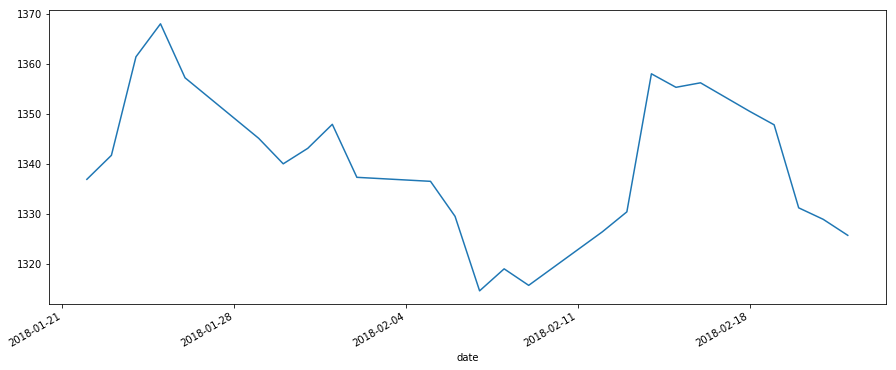

date
2018-02-22    1325.7
2018-02-22    1325.7
2018-02-21    1328.9
2018-02-20    1331.2
2018-02-19    1347.8
Name: price, dtype: float64

In [34]:
ts = data['price']
ts.plot()
plt.show()
ts.head()

In [35]:
TS = np.array(ts)
num_periods = 5
f_horizon = 1

x_data = TS[:len(TS)-(len(TS)%num_periods)]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = TS[1:(len(TS)-(len(TS)%num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)


In [36]:
def test_data(series, forecast, num_periods):
    test_x_setup = series[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    
    testY = series[-(num_periods):].reshape(-1, num_periods, 1)
    
    return testX, testY


In [37]:
X_test, Y_test = test_data(TS, f_horizon, num_periods)


In [38]:
tf.reset_default_graph()

num_periods = 5
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [39]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep%100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE: ', mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE:  43468628.0
100 	MSE:  1838045.0
200 	MSE:  62970.496
300 	MSE:  2356.4832
400 	MSE:  2124.5083
500 	MSE:  2041.1149
600 	MSE:  1982.8978
700 	MSE:  1936.2941
800 	MSE:  1885.3672
900 	MSE:  1833.3575
[[[1346.7684]
  [1361.4032]
  [1363.267 ]
  [1351.5209]
  [1338.7672]]]


Text(0.5,0,'Periods')

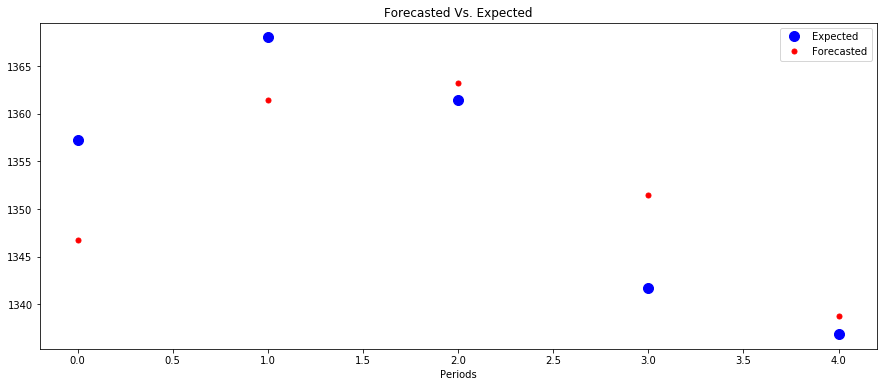

In [40]:
plt.title('Forecasted Vs. Expected')
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Expected')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecasted')
plt.legend(loc='best')
plt.xlabel('Periods')
